In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import argparse
import torch
import pandas as pd
import net
import spacy
import numpy as np
from visualize import visualize
from IPython.display import Image
from IPython.display import display
from preprocessing import read_data, sentence_reader
from tools import revert_mapping
from forest import calc_embedding
from scipy.spatial.distance import cosine

In [2]:
# load evaluation data
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('/home/arne/devel/ML/data/corpora/SICK/sick_test_annotated/SICK_test_annotated_edited.txt', delimiter='\t')
df = df.set_index(['pair_ID'])
df[['entailment_judgment']] = df[['entailment_judgment']].astype(str)
df[['relatedness_score_gold']] = df[['relatedness_score']]
# filter by entailment
# df = df[(df.entailment_judgment == 'ENTAILMENT')]

df[['sentence_A','sentence_B','relatedness_score', 'entailment_judgment']].to_csv('~/devel/ML/data/corpora/SICK/scores_gold.txt', sep='\t', encoding='utf-8')
df

,sentence_A,sentence_B,relatedness_score,entailment_judgment,relatedness_score_gold
pair_ID,,,,,
6,There is no boy playing outdoors and there is no man smiling,A group of kids is playing in a yard and an old man is standing in the background,3.300,NEUTRAL,3.300
7,A group of boys in a yard is playing and a man is standing in the background,The young boys are playing outdoors and the man is smiling nearby,3.700,NEUTRAL,3.700
8,A group of children is playing in the house and there is no man standing in the background,The young boys are playing outdoors and the man is smiling nearby,3.000,NEUTRAL,3.000
10,A brown dog is attacking another animal in front of the tall man in pants,A brown dog is attacking another animal in front of the man in pants,4.900,ENTAILMENT,4.900
11,A brown dog is attacking another animal in front of the man in pants,A brown dog is helping another animal in front of the man in pants,3.665,NEUTRAL,3.665
13,Two dogs are wrestling and hugging,There is no dog wrestling and hugging,3.300,CONTRADICTION,3.300
15,A brown dog is attacking another animal in front of the man in pants,There is no dog wrestling and hugging,2.700,NEUTRAL,2.700
16,Two dogs are wrestling and hugging,A brown dog is attacking another animal in front of the tall man in pants,2.900,NEUTRAL,2.900
17,Two dogs are wrestling and hugging,A brown dog is helping another animal in front of the man in pants,2.300,NEUTRAL,2.300


In [3]:
# load model
net = torch.load('/home/arne/ML/data/summaries/train_2017-02-03_15:54:26/model-04')
data_maps_reverse = {}
for key in net.data_maps:
    data_maps_reverse[key] = revert_mapping(net.data_maps[key])
    

In [4]:
nlp = spacy.load('en')
nlp.pipeline = [nlp.tagger, nlp.parser]

In [5]:
def calc_sentence_embedding(sentence, vis = False):
    seq_data, seq_types, seq_parents, seq_edges = read_data(sentence_reader, nlp, net.data_maps, max_forest_count=net.max_forest_count,
                  max_sen_length=net.slice_size, args={'sentence': sentence})
    
    try:
        embedding = calc_embedding(net, seq_data, seq_types, seq_parents, seq_edges)
    except AssertionError as e:
        visualize('forest_temp.png', (seq_data, seq_types, seq_parents, seq_edges), data_maps_reverse, nlp.vocab)
        img = Image('forest_temp.png')
        display(img)
        print(str(e) + ": '" + sentence + "'")
        return None
        
    if vis == True:
        visualize('forest_temp.png', (seq_data, seq_types, seq_parents, seq_edges), data_maps_reverse, nlp.vocab)
        img = Image('forest_temp.png')
        display(img)
   
    return embedding
        

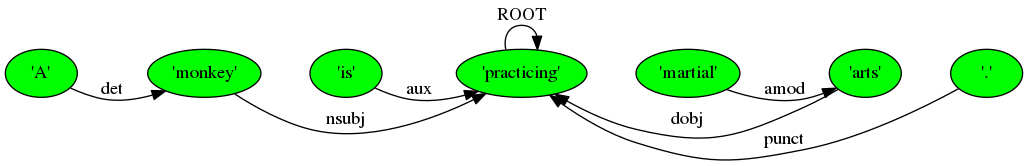

In [6]:
embedding_ref = calc_sentence_embedding('A monkey is practicing martial arts.', True)
#calc_sentence_embedding("A girl from Asia, in front of a brick window, doesn't look surprised.", True)

In [7]:
def get_embedding(sentence):
        # create data arrays for sentence_A, visualize it and calc embedding
    embedding = calc_sentence_embedding(sentence + '.', False)
    if embedding is None:
        embedding = np.zeros([net.dim])
    return embedding

def embeddings(row):
    embedding_A = calc_sentence_embedding(row.sentence_A + '.', False)
    embedding_B = calc_sentence_embedding(row.sentence_B + '.', False)
    
    if embedding_A is None or embedding_B is None:
        return pd.Series(np.zeros([1 + net.dim * 2]))
    else:
        return pd.Series(np.concatenate(([1.], embedding_A, embedding_B)))
    
def norm_relatedness_score(row):
    return (row.relatedness_score_gold - 1.0) / 4.0
    

        

In [8]:
df['relatedness_score_gold_normal'] = df.apply(norm_relatedness_score, axis=1)

newcols_captions = ['valid'] + ['embedding_A#'+str(x) for x in range(net.dim)] + ['embedding_B#'+str(x) for x in range(net.dim)]
df[newcols_captions] = df.apply(embeddings, axis=1)
df

,sentence_A,sentence_B,relatedness_score,entailment_judgment,relatedness_score_gold,relatedness_score_gold_normal,valid,embedding_A#0,embedding_A#1,embedding_A#2,...,embedding_B#290,embedding_B#291,embedding_B#292,embedding_B#293,embedding_B#294,embedding_B#295,embedding_B#296,embedding_B#297,embedding_B#298,embedding_B#299
pair_ID,,,,,,,,,,,,,,,,,,,,,
6,There is no boy playing outdoors and there is no man smiling,A group of kids is playing in a yard and an old man is standing in the background,3.300,NEUTRAL,3.300,0.57500,1.0,1.481895e+01,1.505573e+01,1.394092e+01,...,2.132771e+00,2.528819e+00,2.358826e+00,2.455515e+00,2.902297e+00,2.254036e+00,2.522325e+00,2.519971e+00,2.766227e+00,2.210083e+00
7,A group of boys in a yard is playing and a man is standing in the background,The young boys are playing outdoors and the man is smiling nearby,3.700,NEUTRAL,3.700,0.67500,1.0,2.202819e+00,3.616791e+00,3.017103e+00,...,3.595814e+00,3.800230e+00,3.864367e+00,3.859114e+00,4.111220e+00,3.846417e+00,4.226210e+00,3.754323e+00,4.182457e+00,3.897987e+00
8,A group of children is playing in the house and there is no man standing in the background,The young boys are playing outdoors and the man is smiling nearby,3.000,NEUTRAL,3.000,0.50000,1.0,1.988243e+01,2.015579e+01,1.947710e+01,...,3.595814e+00,3.800230e+00,3.864367e+00,3.859114e+00,4.111220e+00,3.846417e+00,4.226210e+00,3.754323e+00,4.182457e+00,3.897987e+00
10,A brown dog is attacking another animal in front of the tall man in pants,A brown dog is attacking another animal in front of the man in pants,4.900,ENTAILMENT,4.900,0.97500,1.0,-2.008655e-01,6.480901e-01,-6.518339e-02,...,-5.422445e-02,3.281974e-01,-8.054487e-02,-9.742894e-02,2.623821e-02,-1.134703e-01,-3.138504e-01,5.178726e-02,5.575531e-01,-1.050022e-01
11,A brown dog is attacking another animal in front of the man in pants,A brown dog is helping another animal in front of the man in pants,3.665,NEUTRAL,3.665,0.66625,1.0,-3.175999e-01,4.797543e-01,-2.129392e-01,...,-1.699808e-01,3.118900e-01,-3.519117e-02,2.328876e-01,1.850692e-01,3.856160e-03,-2.534412e-01,-1.126960e-01,3.329793e-01,-2.154495e-01
13,Two dogs are wrestling and hugging,There is no dog wrestling and hugging,3.300,CONTRADICTION,3.300,0.57500,1.0,1.534862e-01,8.917518e-01,1.845156e-01,...,9.554447e+02,9.156913e+02,9.526797e+02,9.962005e+02,1.012073e+03,9.621303e+02,9.775632e+02,1.021123e+03,9.903849e+02,1.014848e+03
15,A brown dog is attacking another animal in front of the man in pants,There is no dog wrestling and hugging,2.700,NEUTRAL,2.700,0.42500,1.0,-3.175999e-01,4.797543e-01,-2.129392e-01,...,9.554447e+02,9.156913e+02,9.526797e+02,9.962005e+02,1.012073e+03,9.621303e+02,9.775632e+02,1.021123e+03,9.903849e+02,1.014848e+03
16,Two dogs are wrestling and hugging,A brown dog is attacking another animal in front of the tall man in pants,2.900,NEUTRAL,2.900,0.47500,1.0,1.534863e-01,8.917518e-01,1.845157e-01,...,9.844013e-02,5.401539e-01,1.185849e-01,5.522822e-02,1.593058e-01,1.201152e-01,-1.634278e-01,1.782380e-01,7.231587e-01,3.264495e-02
17,Two dogs are wrestling and hugging,A brown dog is helping another animal in front of the man in pants,2.300,NEUTRAL,2.300,0.32500,1.0,1.534863e-01,8.917518e-01,1.845157e-01,...,-1.699808e-01,3.118900e-01,-3.519117e-02,2.328876e-01,1.850692e-01,3.856160e-03,-2.534412e-01,-1.126960e-01,3.329793e-01,-2.154495e-01


In [9]:
# show invalid
df[df['valid'] != 1.]

,sentence_A,sentence_B,relatedness_score,entailment_judgment,relatedness_score_gold,relatedness_score_gold_normal,valid,embedding_A#0,embedding_A#1,embedding_A#2,...,embedding_B#290,embedding_B#291,embedding_B#292,embedding_B#293,embedding_B#294,embedding_B#295,embedding_B#296,embedding_B#297,embedding_B#298,embedding_B#299
pair_ID,,,,,,,,,,,,,,,,,,,,,


In [10]:

#data = df.ix[:, 7:] 
cols_embedding = [col for col in list(df) if col.startswith('embedding')]
data = df[df['valid'] == 1.][cols_embedding]
target = df['relatedness_score_gold_normal']
data

,embedding_A#0,embedding_A#1,embedding_A#2,embedding_A#3,embedding_A#4,embedding_A#5,embedding_A#6,embedding_A#7,embedding_A#8,embedding_A#9,...,embedding_B#290,embedding_B#291,embedding_B#292,embedding_B#293,embedding_B#294,embedding_B#295,embedding_B#296,embedding_B#297,embedding_B#298,embedding_B#299
pair_ID,,,,,,,,,,,,,,,,,,,,,
6,1.481895e+01,1.505573e+01,1.394092e+01,1.357818e+01,1.346513e+01,1.338842e+01,1.439665e+01,1.397811e+01,1.439723e+01,1.383673e+01,...,2.132771e+00,2.528819e+00,2.358826e+00,2.455515e+00,2.902297e+00,2.254036e+00,2.522325e+00,2.519971e+00,2.766227e+00,2.210083e+00
7,2.202819e+00,3.616791e+00,3.017103e+00,2.595895e+00,2.793962e+00,2.693227e+00,3.303231e+00,3.027850e+00,2.722248e+00,3.404314e+00,...,3.595814e+00,3.800230e+00,3.864367e+00,3.859114e+00,4.111220e+00,3.846417e+00,4.226210e+00,3.754323e+00,4.182457e+00,3.897987e+00
8,1.988243e+01,2.015579e+01,1.947710e+01,1.933250e+01,1.835798e+01,1.874279e+01,1.864423e+01,1.928027e+01,1.982570e+01,1.891161e+01,...,3.595814e+00,3.800230e+00,3.864367e+00,3.859114e+00,4.111220e+00,3.846417e+00,4.226210e+00,3.754323e+00,4.182457e+00,3.897987e+00
10,-2.008655e-01,6.480901e-01,-6.518339e-02,2.793853e-01,6.147581e-02,3.717916e-01,4.470917e-01,2.080033e-01,1.109855e-01,5.425423e-02,...,-5.422445e-02,3.281974e-01,-8.054487e-02,-9.742894e-02,2.623821e-02,-1.134703e-01,-3.138504e-01,5.178726e-02,5.575531e-01,-1.050022e-01
11,-3.175999e-01,4.797543e-01,-2.129392e-01,9.621654e-02,-1.311972e-01,2.553936e-01,2.150187e-01,3.268419e-02,-6.978343e-02,-1.055907e-01,...,-1.699808e-01,3.118900e-01,-3.519117e-02,2.328876e-01,1.850692e-01,3.856160e-03,-2.534412e-01,-1.126960e-01,3.329793e-01,-2.154495e-01
13,1.534862e-01,8.917518e-01,1.845156e-01,2.076448e-01,7.819179e-01,5.862191e-01,1.109291e+00,2.771876e-01,6.977158e-01,2.271466e-01,...,9.554447e+02,9.156913e+02,9.526797e+02,9.962005e+02,1.012073e+03,9.621303e+02,9.775632e+02,1.021123e+03,9.903849e+02,1.014848e+03
15,-3.175999e-01,4.797543e-01,-2.129392e-01,9.621654e-02,-1.311972e-01,2.553936e-01,2.150187e-01,3.268419e-02,-6.978343e-02,-1.055907e-01,...,9.554447e+02,9.156913e+02,9.526797e+02,9.962005e+02,1.012073e+03,9.621303e+02,9.775632e+02,1.021123e+03,9.903849e+02,1.014848e+03
16,1.534863e-01,8.917518e-01,1.845157e-01,2.076447e-01,7.819179e-01,5.862191e-01,1.109291e+00,2.771876e-01,6.977158e-01,2.271466e-01,...,9.844013e-02,5.401539e-01,1.185849e-01,5.522822e-02,1.593058e-01,1.201152e-01,-1.634278e-01,1.782380e-01,7.231587e-01,3.264495e-02
17,1.534863e-01,8.917518e-01,1.845157e-01,2.076447e-01,7.819179e-01,5.862191e-01,1.109291e+00,2.771876e-01,6.977158e-01,2.271466e-01,...,-1.699808e-01,3.118900e-01,-3.519117e-02,2.328876e-01,1.850692e-01,3.856160e-03,-2.534412e-01,-1.126960e-01,3.329793e-01,-2.154495e-01


In [11]:
# taken from http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Notes/IPython%20Notebook%20-%20Regression.html
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

In [12]:
print(data.shape)
print(target.shape)

(4926, 600)
(4926,)


In [25]:
#x = [data.values[i] * data.values[i+net.dim] for i in range(net.dim)]
x = data.ix[:, :300].values * data.ix[:, 300:].values
y = target.values


In [26]:
# Create linear regression object
linreg = LinearRegression()

# Train the model using the training sets
linreg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
# Let's see predictions for the first 10 instances
print(linreg.predict(x[:10]))

[ 0.63264033  0.63264033  0.63264033  0.63264033  0.63264033  0.63264032
  0.63264033  0.63264033  0.63264033  0.63264033]


In [28]:
# Compute RMSE on training data
# p = np.array([linreg.predict(xi) for xi in x])
p = linreg.predict(x)
# Now we can constuct a vector of errors
err = abs(p-y)

# Let's see the error on the first 10 predictions
print(err[:10])

[ 0.05764033  0.04235967  0.13264033  0.34235967  0.03360967  0.05764032
  0.20764033  0.15764033  0.30764033  0.34235967]


In [29]:
# Dot product of error vector with itself gives us the sum of squared errors
total_error = np.dot(err,err)
# Compute RMSE
rmse_train = np.sqrt(total_error/len(p))
print(rmse_train)

0.252432832485


In [30]:
# We can view the regression coefficients
print('Regression Coefficients: \n', linreg.coef_)

Regression Coefficients: 
 [ -4.04370284e-13  -6.05975689e-13   1.17414264e-12  -4.63343253e-13
  -5.00163177e-13  -6.41581458e-13  -2.91065905e-12  -1.83887123e-12
   1.76292410e-12   2.42318212e-12   6.92712100e-13   1.24528246e-12
   3.54460376e-12   9.70223950e-14   3.12548830e-14  -2.36183875e-12
   1.80294575e-12   1.44194478e-12  -1.37589655e-12   9.95098593e-13
   3.84142351e-12  -2.25640829e-12  -2.21573974e-12  -6.10736097e-13
   4.80472252e-13  -2.10494071e-12   3.59645863e-12   1.58044546e-12
   4.16805111e-12  -7.92493751e-13  -9.65042720e-13   1.73477854e-12
  -7.38947388e-12   3.40342673e-12  -5.35093590e-13   9.78698349e-13
  -3.04338040e-12  -1.61483927e-12  -3.53304063e-13   2.88846811e-12
  -5.03396822e-12   1.56687138e-13  -5.65229130e-12  -1.82431286e-12
   2.59430109e-12  -2.54369574e-13  -2.82530403e-13  -1.91714703e-12
   1.41246327e-12   1.04672907e-12  -2.57231851e-12   4.79251508e-12
   7.10585864e-13  -4.27782490e-12   1.19298035e-12   6.16454824e-12
   1.32

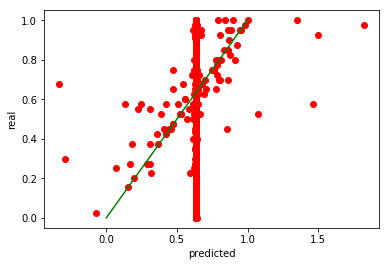

In [31]:
import pylab as pl
# Plot outputs
%matplotlib inline
pl.plot(p, y,'ro')
pl.plot([0,1],[0,1], 'g-')
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [34]:
# Now let's compute RMSE using 10-fold x-validation
pc = np.empty([len(x)])
yc = np.empty([len(x)])

kf = KFold(n_splits=len(x))
xval_err = 0
for train, test in kf.split(x):
    linreg.fit(x[train],y[train])
    # p = np.array([linreg.predict(xi) for xi in x[test]])
    p = linreg.predict(x[test])
    yc[test] = y[test][0]
    pc[test] = p[0]
    e = p-y[test]
    xval_err += np.dot(e,e)
    
rmse_10cv = np.sqrt(xval_err/len(x))


method_name = 'Simple Linear Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %rmse_10cv)

Method: Simple Linear Regression
RMSE on training: 0.2524
RMSE on 10-fold CV: 8328714.3540


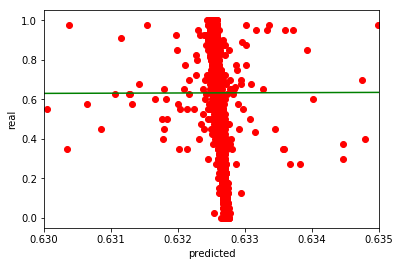

In [42]:
# Plot outputs
%matplotlib inline
pl.plot(pc, yc,'ro')
pl.plot([0,1],[0,1], 'g-')
pl.xlim(.63, .635)
pl.xlabel('predicted')
pl.ylabel('real')
pl.show()

In [8]:
#i = 0
for row in df.itertuples():
    #if i == 3:
    #    break
    
    # create data arrays for sentence_A, visualize it and calc embedding
    embedding_A = calc_sentence_embedding(row.sentence_A + '.', False)
    #print(embedding_A)
    
    # create data arrays for sentence_A, visualize it and calc embedding
    embedding_B = calc_sentence_embedding(row.sentence_B + '.', False)
    #print(embedding_B)
    
    #df.at[row.Index, 'embedding_A'] = embedding_A
    #df.at[row.Index, 'embedding_B'] = embedding_B
    
    
    if embedding_A is not None and embedding_B is not None:
        df.at[row.Index, 'relatedness_score_cos'] = cosine(embedding_A, embedding_B)
        df.at[row.Index, 'relatedness_score_ref_A'] = cosine(embedding_A, embedding_ref)
        df.at[row.Index, 'relatedness_score_ref_B'] = cosine(embedding_B, embedding_ref)
        #print(embedding_A, embedding_B)
        df.at[row.Index, 'embedding_A'] = embedding_A
        df.at[row.Index, 'embedding_B'] = embedding_B
    
    #print(df.loc[row.Index])
    df.at[row.Index, 'entailment_judgment'] = 'NA'
    #i += 1

#print(i)
df

ValueError: Must have equal len keys and value when setting with an iterable

In [8]:
m = df[['relatedness_score_cos']].min()[0]
d = (df[['relatedness_score_cos']].max() - m)[0]
print('min:', m)
print('dif:', d)

min: -1.86436549088e-07
dif: 1.86798180989


In [9]:
#df['relatedness_score'] = df['relatedness_score_cos'].subtract(m).divide(d).multiply(4).add(1)
df['relatedness_score'] = df['relatedness_score_cos']
m = df[['relatedness_score']].min()
d = df[['relatedness_score']].max() - m
print('min:', m)
print('dif:', d)

min: relatedness_score   -1.864365e-07
dtype: float64
dif: relatedness_score    1.867982
dtype: float64


In [10]:
df

,sentence_A,sentence_B,relatedness_score,entailment_judgment,relatedness_score_gold,relatedness_score_cos,relatedness_score_ref_A,relatedness_score_ref_B
pair_ID,,,,,,,,
6,There is no boy playing outdoors and there is no man smiling,A group of kids is playing in a yard and an old man is standing in the background,0.006857,NA,3.300,0.006857,0.003131,0.008018
7,A group of boys in a yard is playing and a man is standing in the background,The young boys are playing outdoors and the man is smiling nearby,0.002461,NA,3.700,0.002461,0.006409,0.004272
8,A group of children is playing in the house and there is no man standing in the background,The young boys are playing outdoors and the man is smiling nearby,0.002001,NA,3.000,0.002001,0.002908,0.004272
10,A brown dog is attacking another animal in front of the tall man in pants,A brown dog is attacking another animal in front of the man in pants,0.141413,NA,4.900,0.141413,0.404429,0.887834
11,A brown dog is attacking another animal in front of the man in pants,A brown dog is helping another animal in front of the man in pants,0.474652,NA,3.665,0.474652,0.887834,1.175002
13,Two dogs are wrestling and hugging,There is no dog wrestling and hugging,0.114650,NA,3.300,0.114650,0.110764,0.002848
15,A brown dog is attacking another animal in front of the man in pants,There is no dog wrestling and hugging,0.906392,NA,2.700,0.906392,0.887834,0.002848
16,Two dogs are wrestling and hugging,A brown dog is attacking another animal in front of the tall man in pants,0.344861,NA,2.900,0.344861,0.110764,0.404429
17,Two dogs are wrestling and hugging,A brown dog is helping another animal in front of the man in pants,1.021155,NA,2.300,1.021155,0.110764,1.175002


In [11]:
df[['relatedness_score', 'entailment_judgment']].to_csv('~/devel/ML/data/corpora/SICK/my_test_scores.txt', sep='\t', encoding='utf-8')

In [12]:
# ~/devel/ML/data/corpora/SICK$ R --no-save --slave --vanilla --args my_test_scores.txt sick_test_annotated/SICK_test_annotated_edited.txt < sick_evaluation.R